# Training a Classifier on Various Perturbed Crystals

This tutorial describes how to set up a database of crystals relevant to identifying a variety of phases using the `ase` package and __rattling__. Rattling is the perturbation of crystals away from their highest symmetry configuration using some displacement distribution. Rattling thus emulates the effect of temperature without the expansion of the lattice. The atoms of the rattled crystals are then each transformed into feature vectors for classification. Classification is here carried out using a varied of methods implemented in `sklearn`.

In [1]:
%matplotlib notebook
import numpy as np
from scipy import interpolate, spatial, stats
import itertools, warnings, copy
from ase.lattice.cubic import FaceCenteredCubic, SimpleCubicFactory
from ase.spacegroup import crystal
from ase.build import nanotube, graphene_nanoribbon
import matplotlib.pylab as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn import linear_model, utils, preprocessing
import sklearn
import atomtoolbox as atb

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

E:\Programs\Anaconda3\envs\py35\lib\site-packages\ase\lattice\spacegroup.py:5: UserWarning: Moved to ase.spacegroup
  warnings.warn('Moved to ase.spacegroup')


## 1. Generating a Collection of Ideal Crystals

In [2]:
a0 = 3.52
L12 = atb.L12Factory()
size = (3,3,3)
atoms_gamma_prime = L12(directions=[[1,0,0],[0,1,0],[0,0,1]], size=size,
                          symbol=["Al","Ni"],pbc=(1,1,1),latticeconstant=a0)
atoms_dict = {"gamma_prime":atoms_gamma_prime}

a = 4.05
atoms_fccAl = crystal('Al', [(0,0,0)], spacegroup=225, cellpar=[a, a, a, 90, 90, 90],
                     size=size)
atoms_dict["fccAl"] = atoms_fccAl

a = 2.87
atoms_bccFe = crystal('Fe', [(0,0,0)], spacegroup=229, cellpar=[a, a, a, 90, 90, 90],
                      size=size)
atoms_dict["bccFe"] = atoms_bccFe

a = 3.21
c = 5.21
atoms_hcpMg = crystal('Mg', [(1./3., 2./3., 3./4.)], spacegroup=194,
                      cellpar=[a, a, c, 90, 90, 120], size=size)
atoms_dict["hcpMg"] = atoms_hcpMg

a = 3.57
atoms_diamond = crystal('C', [(0,0,0)], spacegroup=227, cellpar=[a, a, a, 90, 90, 90],
                        size=size)
atoms_dict["diamond"] = atoms_diamond

a = 5.64
atoms_NaCl = crystal(['Na', 'Cl'], [(0, 0, 0), (0.5, 0.5, 0.5)], spacegroup=225,
                     cellpar=[a, a, a, 90, 90, 90], size=size)
atoms_dict["NaCl"] = atoms_NaCl

a = 4.6
c = 2.95
atoms_rutile = crystal(['Ti', 'O'], basis=[(0, 0, 0), (0.3, 0.3, 0.0)],
                spacegroup=136, cellpar=[a, a, c, 90, 90, 90], size=size)
atoms_dict["rutile"] = atoms_rutile

a = 9.04
atoms_skutterudite = crystal(('Co', 'Sb'),
                       basis=[(0.25, 0.25, 0.25), (0.0, 0.335, 0.158)],
                       spacegroup=204, size=size,
                       cellpar=[a, a, a, 90, 90, 90])
atoms_dict["skutterudite"] = atoms_skutterudite

## 2. Rattling Crystals

rattling  NaCl
rattling  bccFe
rattling  diamond
rattling  fccAl
rattling  gamma_prime
rattling  hcpMg
rattling  rutile
rattling  skutterudite
t_l_flat 71280
rpositions_flat 320, Natoms_flat 320, cells_flat 320, species_flat 320


<IPython.core.display.Javascript object>


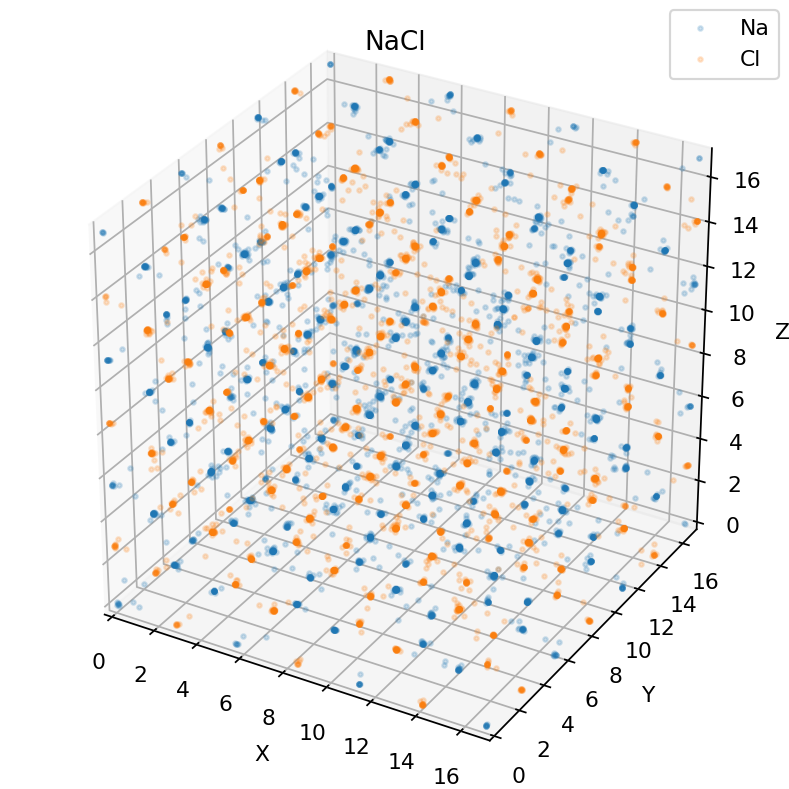

<IPython.core.display.Javascript object>


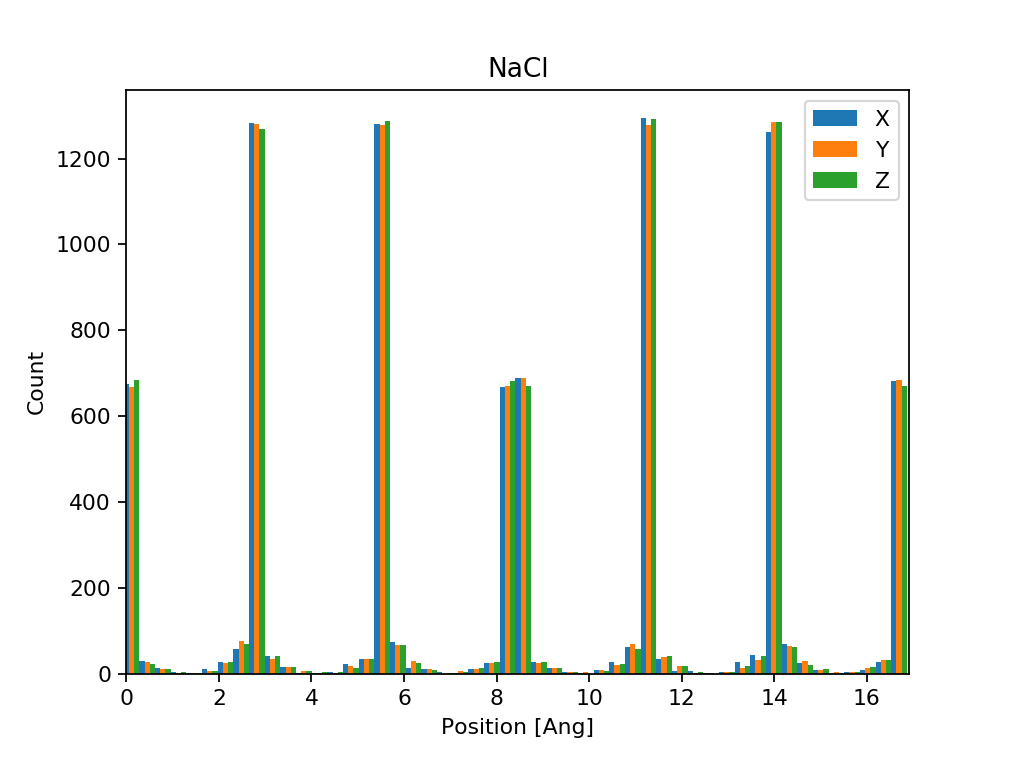

<IPython.core.display.Javascript object>


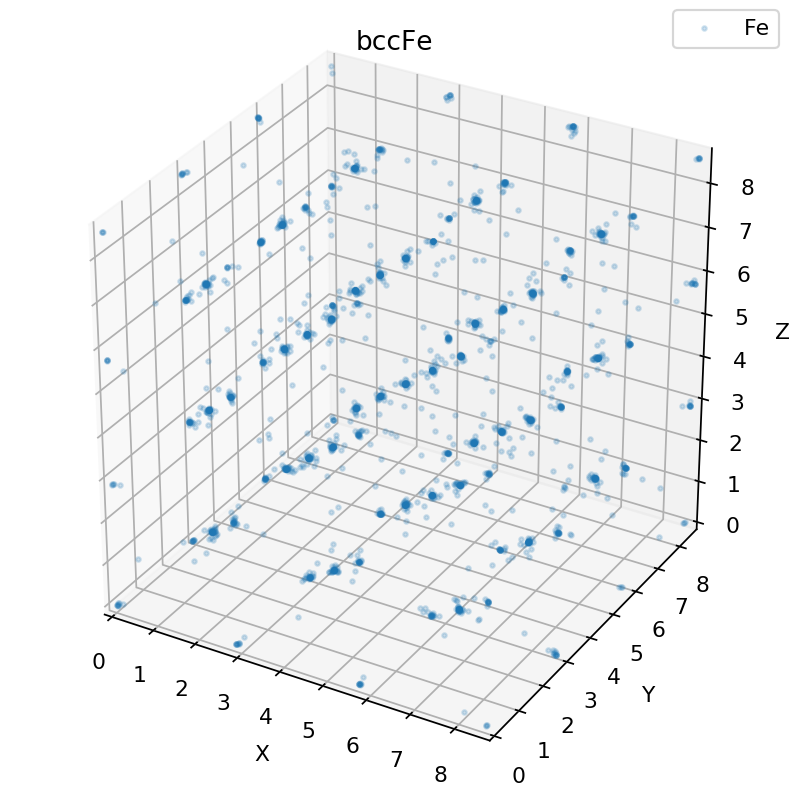

<IPython.core.display.Javascript object>


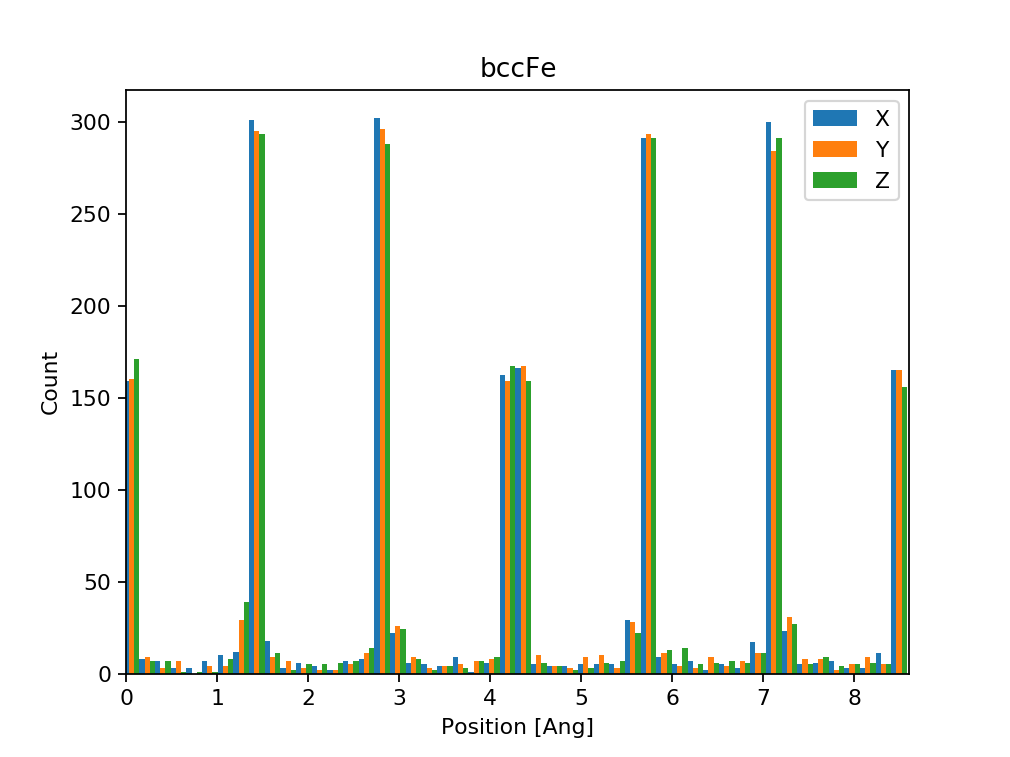

<IPython.core.display.Javascript object>


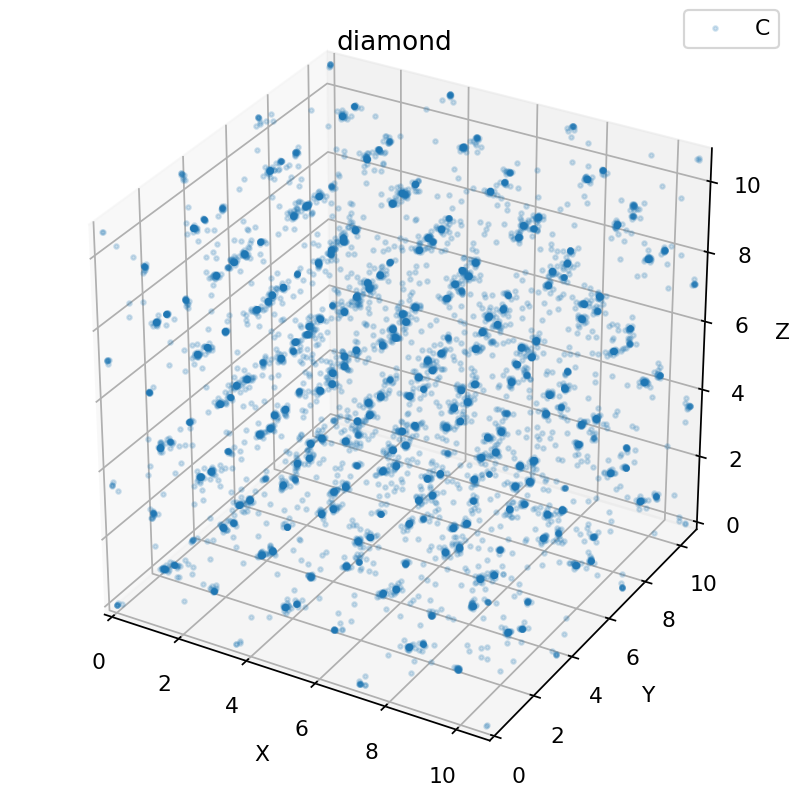

<IPython.core.display.Javascript object>


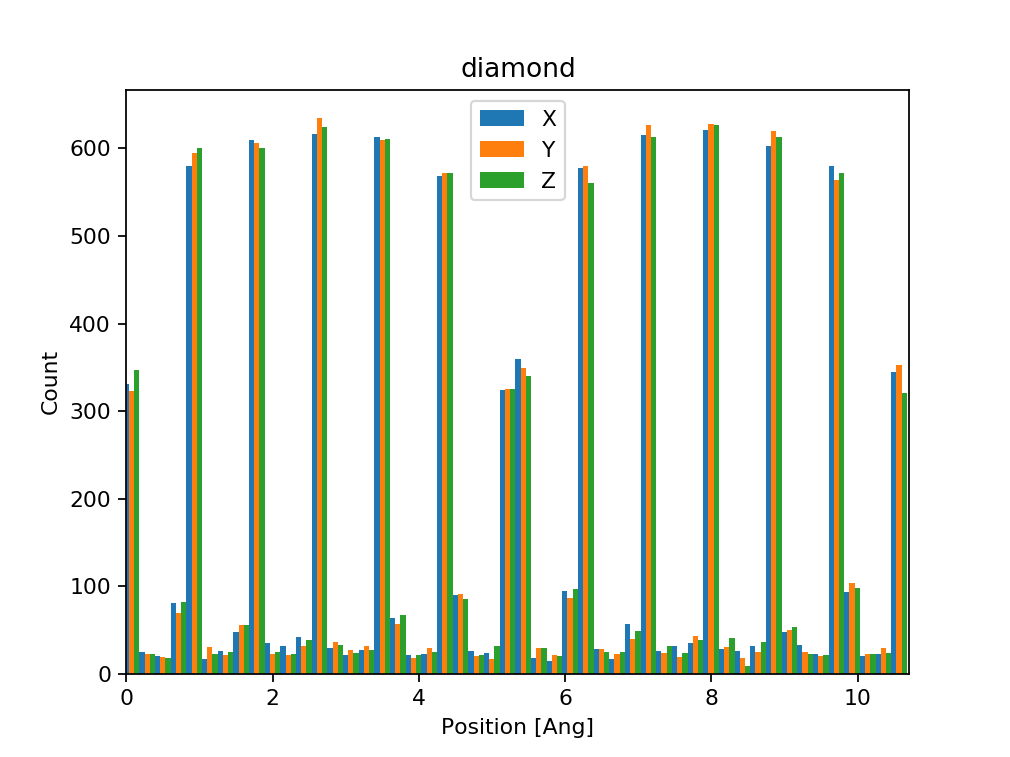

<IPython.core.display.Javascript object>


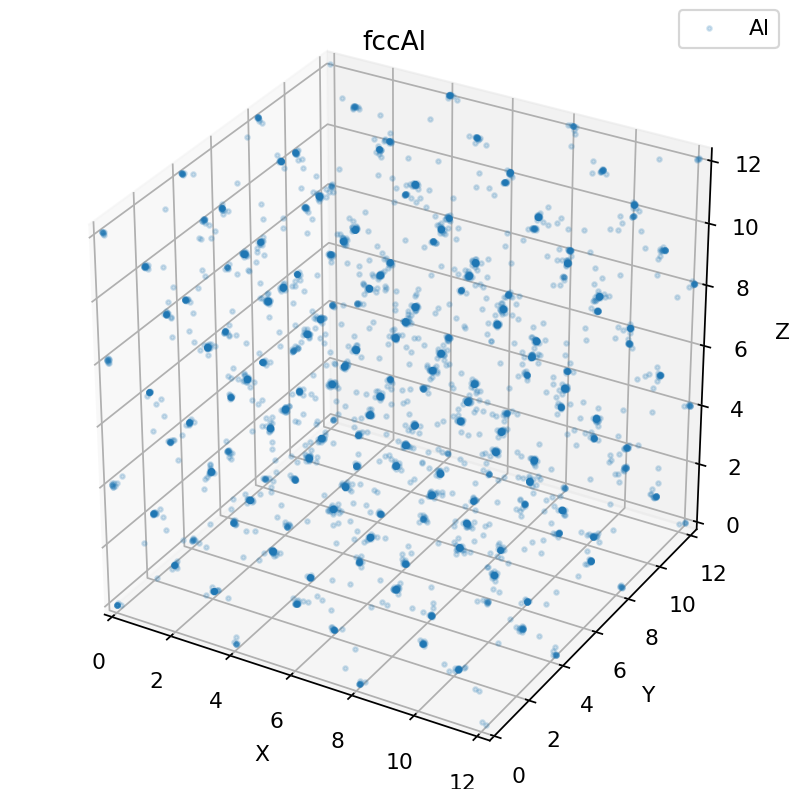

<IPython.core.display.Javascript object>


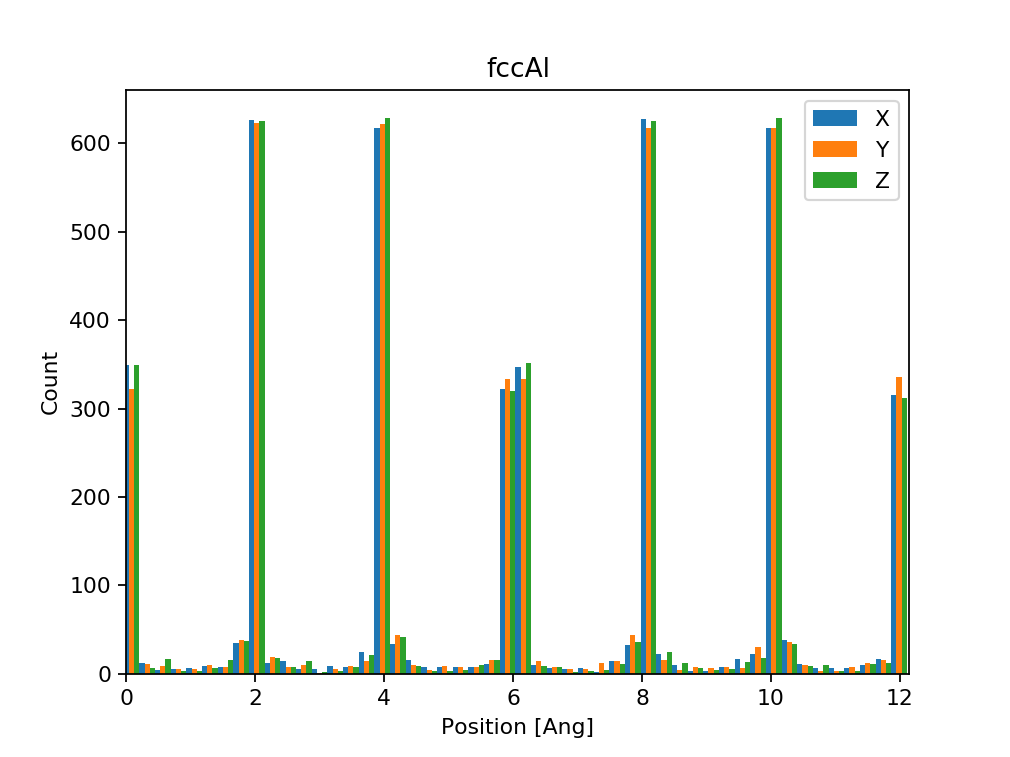

<IPython.core.display.Javascript object>


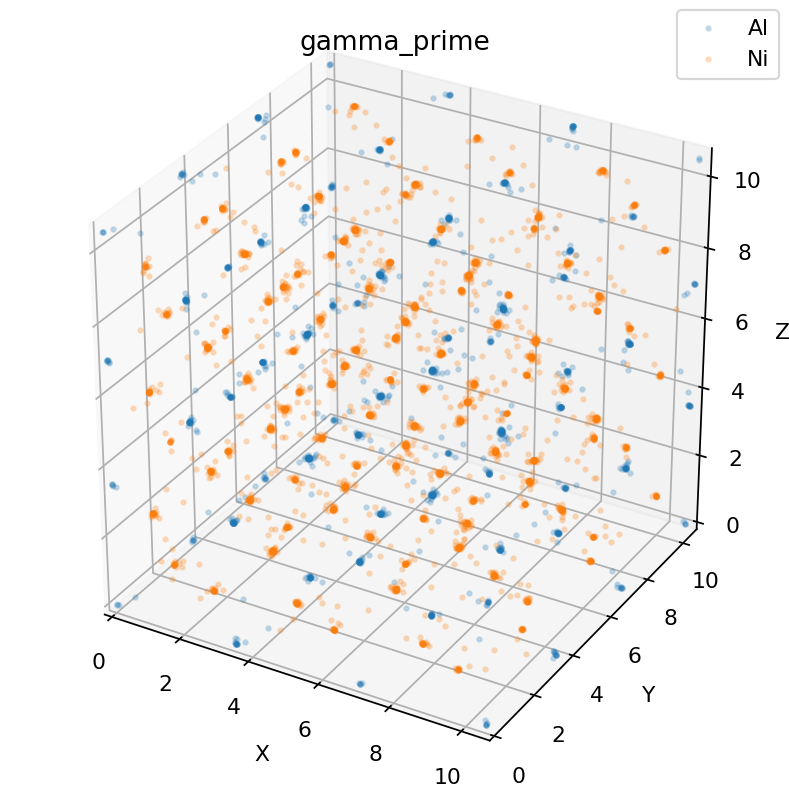

<IPython.core.display.Javascript object>


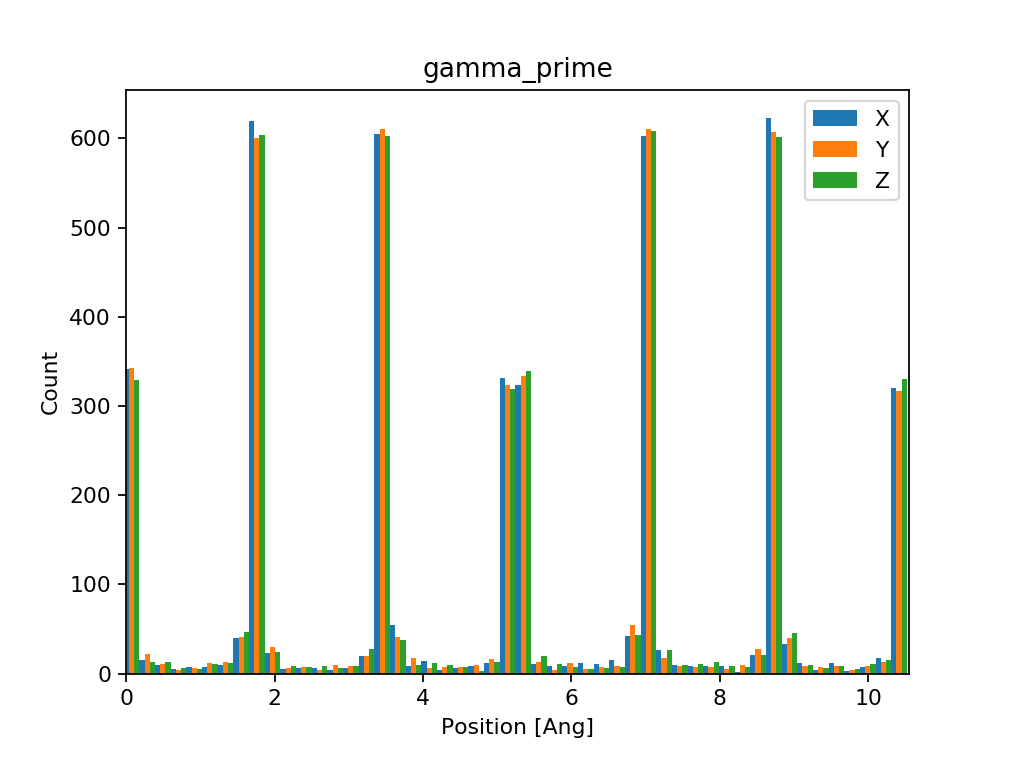

<IPython.core.display.Javascript object>


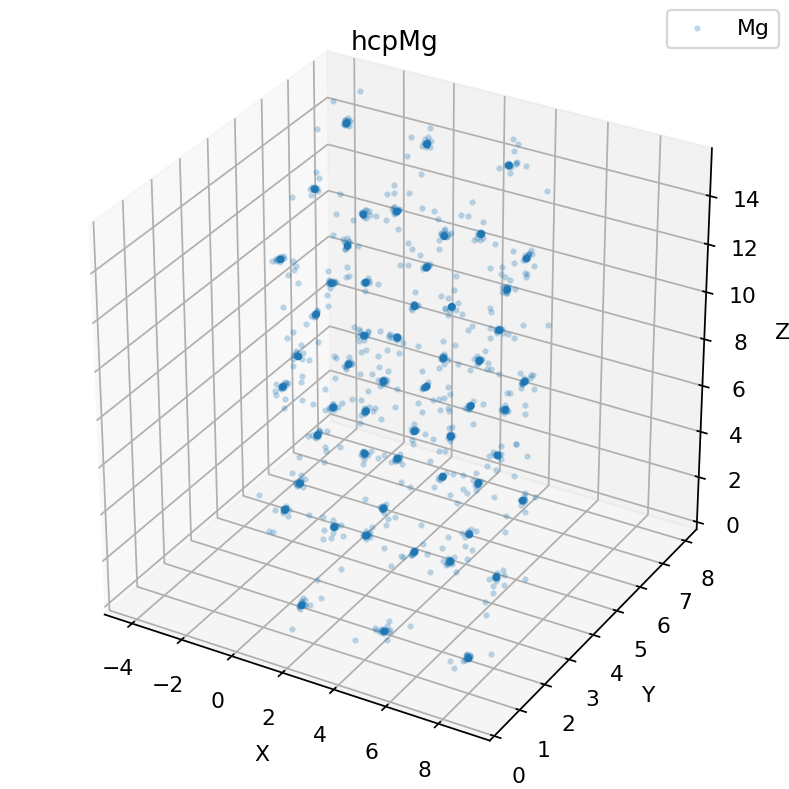

<IPython.core.display.Javascript object>


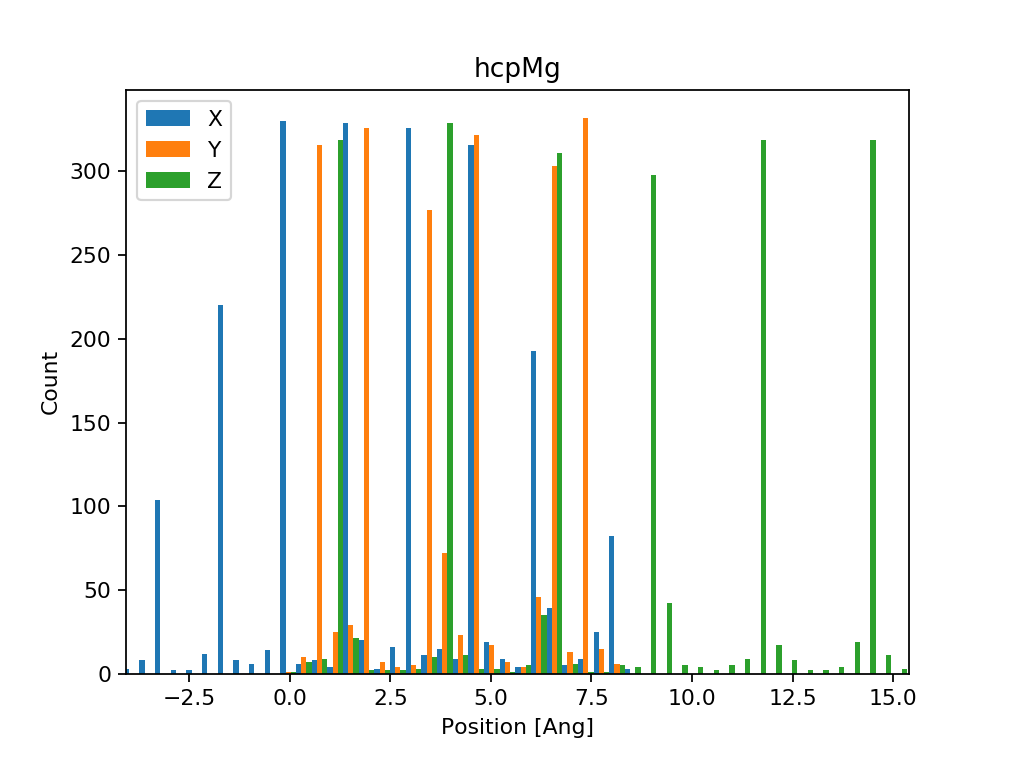

<IPython.core.display.Javascript object>


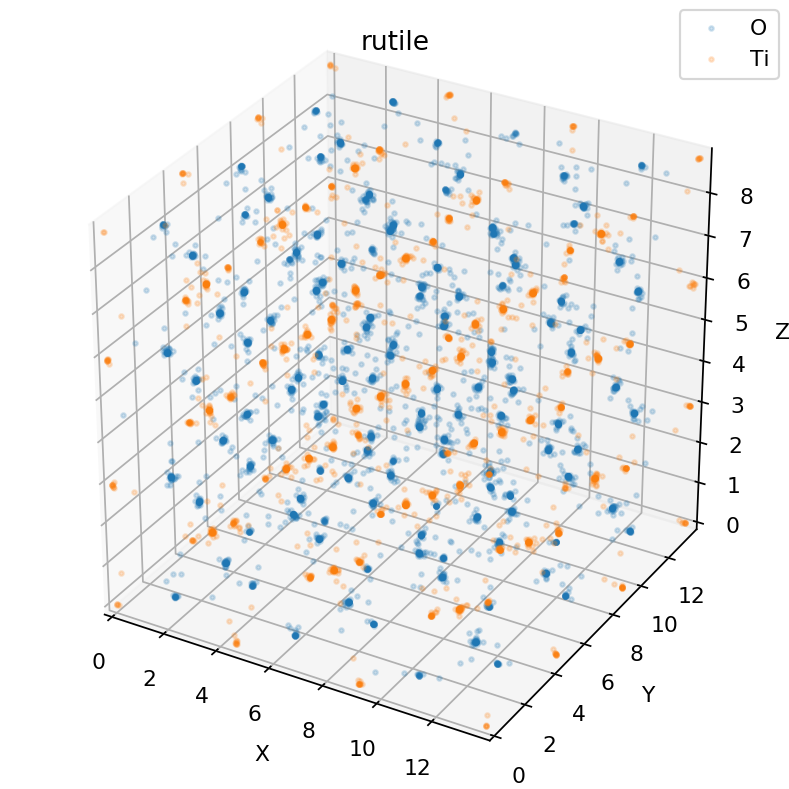

<IPython.core.display.Javascript object>


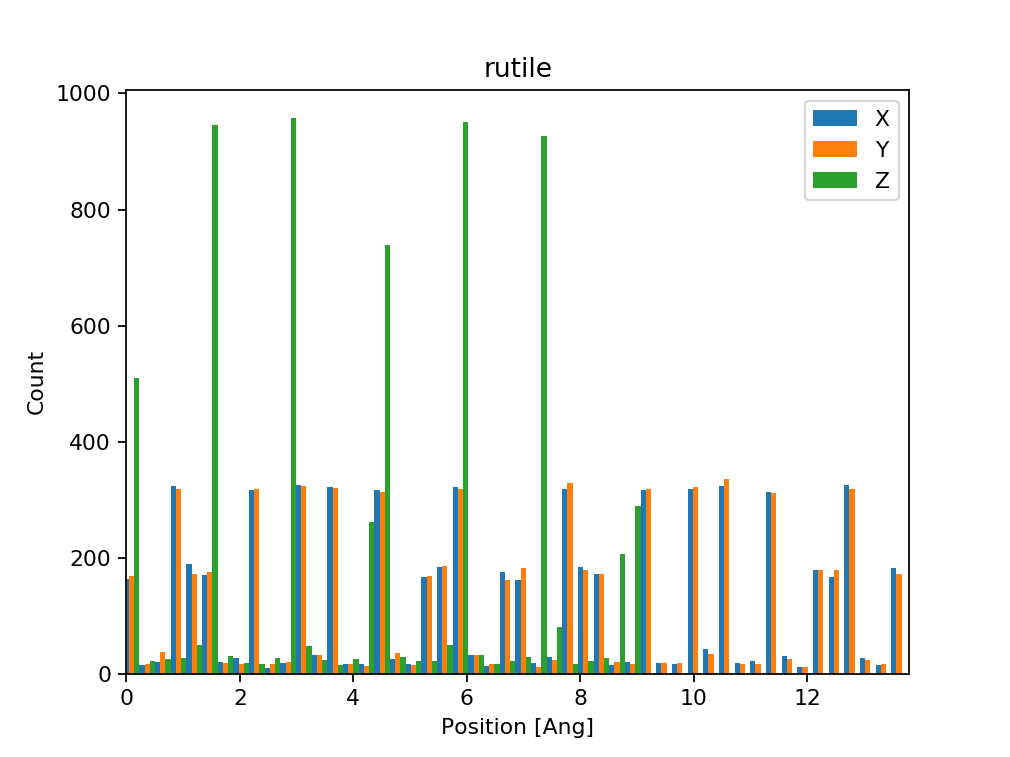

<IPython.core.display.Javascript object>


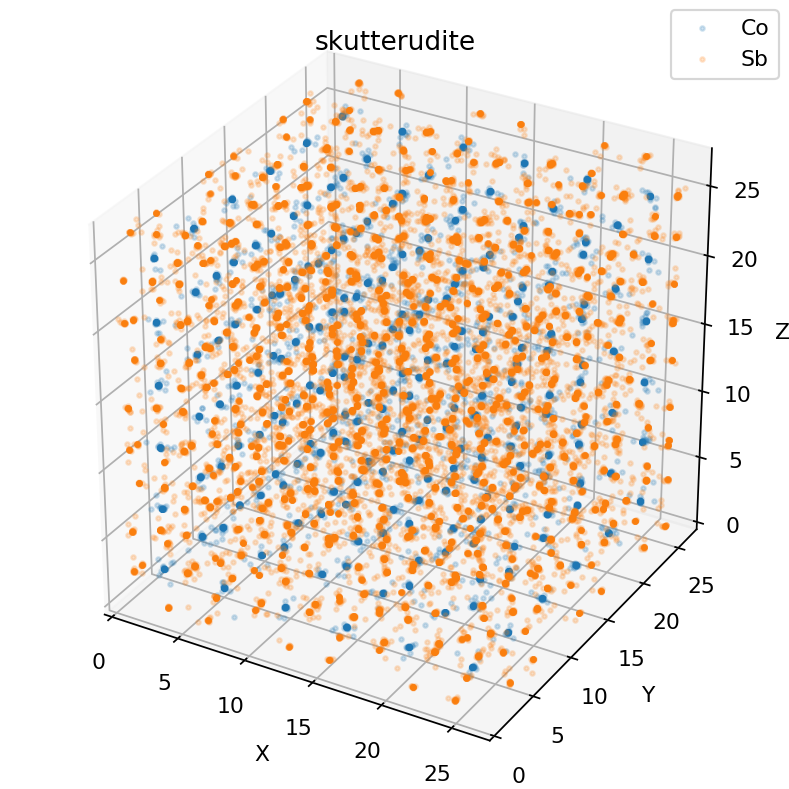

<IPython.core.display.Javascript object>


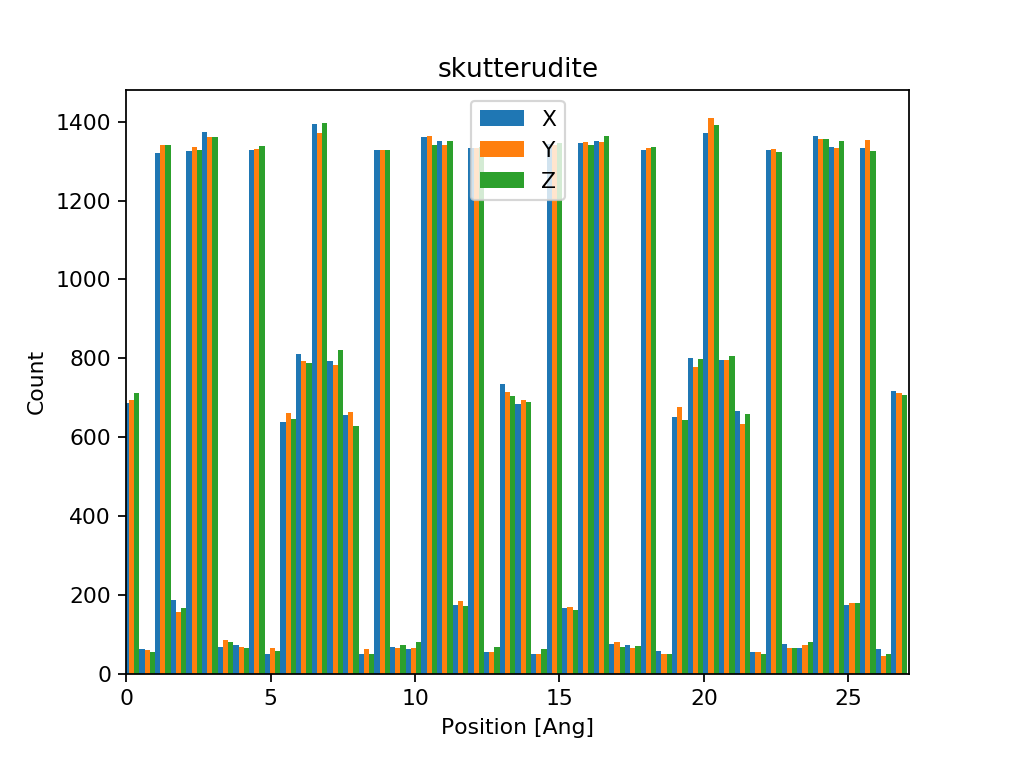

In [3]:
Nrattle = 5
rattle_rvs = [stats.norm(loc=0,scale=.001), stats.norm(loc=0,scale=.005),\
              stats.norm(loc=0,scale=.01), stats.norm(loc=0,scale=.02),\
              stats.norm(loc=0,scale=.03), stats.norm(loc=0,scale=.05),
              stats.norm(loc=0,scale=.1), stats.norm(loc=0,scale=.5)]
#CRs = [atb.CrystalRattler(rattle_rv=rattle_rv) for rattle_rv in rattle_rvs]

rpositions, Natoms, cells, species = None, None, None, None
all_rattled_positions = dict()
t_l = []
for sname in sorted(atoms_dict):
    print("rattling ",sname)
    rpositions, Natoms, cells, species = atb.rattle_crystal_multiple_rvs(Nrattle, rattle_rvs,\
                                atoms_dict[sname], rpositions=rpositions, Natoms=Natoms,\
                                species=species, cells=cells)
    t_l.append([sname for v in range(Nrattle*len(rattle_rvs)*atoms_dict[sname].positions.shape[0])])
    
rpositions_flat, Natoms_flat, cells_flat, species_flat = atb.flattening_rattled_crystal_data(rpositions,\
                                                    Natoms, cells, species)
t_l_flat = np.hstack(t_l)
print("t_l_flat {}".format(len(t_l_flat)))
print("rpositions_flat {}, Natoms_flat {}, cells_flat {}, species_flat {}".format(len(rpositions_flat), len(Natoms_flat), len(cells_flat), len(species_flat)))

Nrvs = len(rattle_rvs)
for i,sname in enumerate(sorted(atoms_dict)):
    atoms = atoms_dict[sname]
    markersizes = {_k:2 for _k in set(atoms.get_chemical_symbols())}
    
    _rpositions = rpositions_flat[i*Nrvs*Nrattle:(i+1)*Nrvs*Nrattle]
    _species = species_flat[i*Nrvs*Nrattle:(i+1)*Nrvs*Nrattle]
    _cells = cells_flat[i*Nrvs*Nrattle:(i+1)*Nrvs*Nrattle]
            
    atb.show_rattled_atoms(_rpositions, species=_species,
                       cells=_cells, markersizes=markersizes, title=sname)

## 3. Setting up Design Matrices

In [4]:
all_filter = lambda s,s_ref: np.array([True for v in range(s.shape[0])])
like_filter = lambda s,s_ref: s == s_ref
unlike_filter = lambda s,s_ref: s != s_ref

r_cut = 4.

tbaf_params = {"k":20,"_range":(0,np.pi),"normed":True,"element_filter":all_filter}
bopf_params = {"k":[4,6,8],"element_filter":all_filter}
dtf_params = {"taper_fun":atb.taper_fun_wrapper(_type="x4ge",a=r_cut,b=1.),"element_filter":all_filter}
detf_params = {"taper_fun":atb.taper_fun_wrapper(_type="x4ge",a=r_cut,b=1.),"element_filter":all_filter,
               "rs_":[0.,1.],"eta_":[1.,1.]}
dctf_params = {"taper_fun":atb.taper_fun_wrapper(_type="x4ge",a=r_cut,b=1.),"element_filter":all_filter,
               "kappa_":[1.,2.]}
dcetf3body_params = {"taper_fun":atb.taper_fun_wrapper(_type="x4ge",a=r_cut,b=1.),"element_filter":all_filter,
                     "xi_":[0.,1.],"lambda_":[1.,1.],"eta_":[1.,.5]}
dcetf3body2_params = {"taper_fun":atb.taper_fun_wrapper(_type="x4ge",a=r_cut,b=1.),"element_filter":all_filter,
                      "xi_":[0.,1.],"lambda_":[1.,1.],"eta_":[1.,.5]}

features_class = [atb.ThreeBodyAngleFeatures, atb.BondOrderParameterFeatures,
             atb.DistanceTaperingFeatures_2body, atb.DistanceExpTaperingFeatures_2body,
             atb.DistanceCosTaperingFeatures_2body, atb.DistanceCosExpTaperingFeatures_3body,
             atb.DistanceCosExpTaperingFeatures_3body2,]
featurer_params = [tbaf_params, bopf_params, dtf_params, detf_params, dctf_params,
                   dcetf3body_params, dcetf3body2_params]

for i in range(len(rpositions_flat)): # looping rattle rv & crystal type
    
    if i%10==0:
        print("{}/{}".format(i+1,len(rpositions_flat)))
    _pos = rpositions_flat[i]
    _cell = cells_flat[i]
    _spec = species_flat[i]

    _Phi = atb.get_crystal_design_matrix(positions=_pos, species=_spec, cell=_cell, r_cut=r_cut, 
                                    features_class=features_class,
                                    params_features=featurer_params, return_force=False)
    if i == 0:
        Phi = np.copy(_Phi)
    else:
        Phi = np.vstack((Phi,_Phi))
    print("Phi ",Phi.shape)


1/320
Phi  (216, 32)
Phi  (432, 32)
Phi  (648, 32)
Phi  (864, 32)
Phi  (1080, 32)
Phi  (1296, 32)
Phi  (1512, 32)
Phi  (1728, 32)
Phi  (1944, 32)
Phi  (2160, 32)
11/320
Phi  (2376, 32)
Phi  (2592, 32)
Phi  (2808, 32)
Phi  (3024, 32)
Phi  (3240, 32)
Phi  (3456, 32)
Phi  (3672, 32)
Phi  (3888, 32)
Phi  (4104, 32)
Phi  (4320, 32)
21/320
Phi  (4536, 32)
Phi  (4752, 32)
Phi  (4968, 32)
Phi  (5184, 32)
Phi  (5400, 32)
Phi  (5616, 32)
Phi  (5832, 32)
Phi  (6048, 32)
Phi  (6264, 32)
Phi  (6480, 32)
31/320
Phi  (6696, 32)
Phi  (6912, 32)
Phi  (7128, 32)
Phi  (7344, 32)
Phi  (7560, 32)
Phi  (7776, 32)
Phi  (7992, 32)
Phi  (8208, 32)
Phi  (8424, 32)
Phi  (8640, 32)
41/320
Phi  (8694, 32)
Phi  (8748, 32)
Phi  (8802, 32)
Phi  (8856, 32)
Phi  (8910, 32)
Phi  (8964, 32)
Phi  (9018, 32)
Phi  (9072, 32)
Phi  (9126, 32)
Phi  (9180, 32)
51/320
Phi  (9234, 32)
Phi  (9288, 32)
Phi  (9342, 32)
Phi  (9396, 32)
Phi  (9450, 32)
Phi  (9504, 32)
Phi  (9558, 32)
Phi  (9612, 32)
Phi  (9666, 32)
Phi  (9720, 32)
61/

## 4. Generating Labeling & Split into Test and Train Sets

In [5]:
label_map = {k:i for i,k in enumerate(sorted(atoms_dict))}
t = np.array([label_map[v] for v in t_l_flat])
t = np.array(t,dtype=int)
print("\nfinal sizes: t = {}, Phi = {}".format(t.shape,Phi.shape))

Phi_train, Phi_test, t_train, t_test = \
        train_test_split(Phi, t, test_size=.4, random_state=42)
print("train sizes: t = {}, Phi = {}".format(t_train.shape,Phi_train.shape))
print("test sizes: t = {}, Phi = {}".format(t_test.shape,Phi_test.shape))


final sizes: t = (71280,), Phi = (71280, 32)
train sizes: t = (42768,), Phi = (42768, 32)
test sizes: t = (28512,), Phi = (28512, 32)


## 5. Training Classifiers

Example with various classifiers, standardization and test/train splits: http://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html

In [6]:
import time
classifier_names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", 
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes", "QDA"]#,"Gaussian Process",]

classifiers = [KNeighborsClassifier(3),
               SVC(kernel="linear", C=0.025),
               SVC(gamma=2, C=1),
               DecisionTreeClassifier(max_depth=5),
               RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
               MLPClassifier(alpha=1),
               AdaBoostClassifier(),
               GaussianNB(),
               QuadraticDiscriminantAnalysis()]#,
#               GaussianProcessClassifier(1.0 * RBF(1.0)),]

for clf, clf_name in zip(classifiers,classifier_names):
    print("\nprocessing: {}".format(clf_name))
    t0 = time.time()
    clf.fit(Phi_train,t_train)
    
    print(sklearn.metrics.classification_report(t_test,clf.predict(Phi_test), 
                                      target_names=sorted(atoms_dict.keys())))
    #print("train score = {:.3f}, test score = {:.3f}, time = {:.3f}s".format(clf.score(Phi_train,t_train),clf.score(Phi_test,t_test), time.time()-t0))


processing: Nearest Neighbors
              precision    recall  f1-score   support

        NaCl       0.90      0.90      0.90      3455
       bccFe       0.86      0.92      0.89       850
     diamond       1.00      1.00      1.00      3428
       fccAl       0.92      0.94      0.93      1684
 gamma_prime       0.94      0.90      0.92      1717
       hcpMg       0.98      0.89      0.93       874
      rutile       0.94      0.95      0.95      2681
skutterudite       0.97      0.97      0.97     13823

 avg / total       0.95      0.95      0.95     28512


processing: Linear SVM
              precision    recall  f1-score   support

        NaCl       1.00      0.87      0.93      3455
       bccFe       0.98      0.89      0.93       850
     diamond       1.00      1.00      1.00      3428
       fccAl       0.96      0.94      0.95      1684
 gamma_prime       1.00      0.87      0.93      1717
       hcpMg       1.00      0.88      0.94       874
      rutile       0.90

E:\Programs\Anaconda3\envs\py35\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

        NaCl       1.00      0.87      0.93      3455
       bccFe       0.00      0.00      0.00       850
     diamond       1.00      1.00      1.00      3428
       fccAl       0.94      0.95      0.94      1684
 gamma_prime       0.64      0.84      0.73      1717
       hcpMg       1.00      0.88      0.94       874
      rutile       0.88      0.99      0.93      2681
skutterudite       0.96      1.00      0.98     13823

 avg / total       0.91      0.93      0.92     28512


processing: Random Forest
              precision    recall  f1-score   support

        NaCl       1.00      0.87      0.93      3455
       bccFe       1.00      0.79      0.88       850
     diamond       0.99      0.99      0.99      3428
       fccAl       0.99      0.87      0.93      1684
 gamma_prime       0.99      0.87      0.92      1717
       hcpMg       1.00      0.88      0.94       874
      rutile       0.89      0.97      0.93      26

E:\Programs\Anaconda3\envs\py35\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

        NaCl       0.20      0.73      0.31      3455
       bccFe       0.00      0.00      0.00       850
     diamond       1.00      0.99      1.00      3428
       fccAl       0.87      0.12      0.21      1684
 gamma_prime       0.00      0.00      0.00      1717
       hcpMg       0.19      0.89      0.31       874
      rutile       0.40      1.00      0.57      2681
skutterudite       0.38      0.04      0.07     13823

 avg / total       0.42      0.35      0.27     28512


processing: Naive Bayes
              precision    recall  f1-score   support

        NaCl       0.99      0.88      0.93      3455
       bccFe       0.99      0.84      0.91       850
     diamond       1.00      1.00      1.00      3428
       fccAl       1.00      0.88      0.94      1684
 gamma_prime       0.98      0.87      0.92      1717
       hcpMg       0.99      0.88      0.93       874
      rutile       0.81      1.00      0.89      2681

E:\Programs\Anaconda3\envs\py35\lib\site-packages\sklearn\discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


              precision    recall  f1-score   support

        NaCl       0.97      0.89      0.93      3455
       bccFe       0.85      0.94      0.89       850
     diamond       1.00      1.00      1.00      3428
       fccAl       0.98      0.93      0.96      1684
 gamma_prime       0.99      0.88      0.93      1717
       hcpMg       0.42      0.97      0.59       874
      rutile       0.94      0.98      0.96      2681
skutterudite       0.98      0.93      0.95     13823

 avg / total       0.96      0.93      0.94     28512

